In [1]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set up styling
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [4]:
# ---------- CONFIG ----------
BASE = Path(r"E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data")
team_data = pd.read_csv(BASE / "team_gamestate_efficiency.csv")
player_data = pd.read_csv(BASE / "player_gamestate_efficiency.csv")

# Add overall efficiency to team data
team_data['Overall'] = team_data[['Winning', 'Drawing', 'Losing']].mean(axis=1)

print("🎨 Starting Phase 5.1: Core Visualizations")

🎨 Starting Phase 5.1: Core Visualizations


📊 Creating enhanced team performance heatmap...


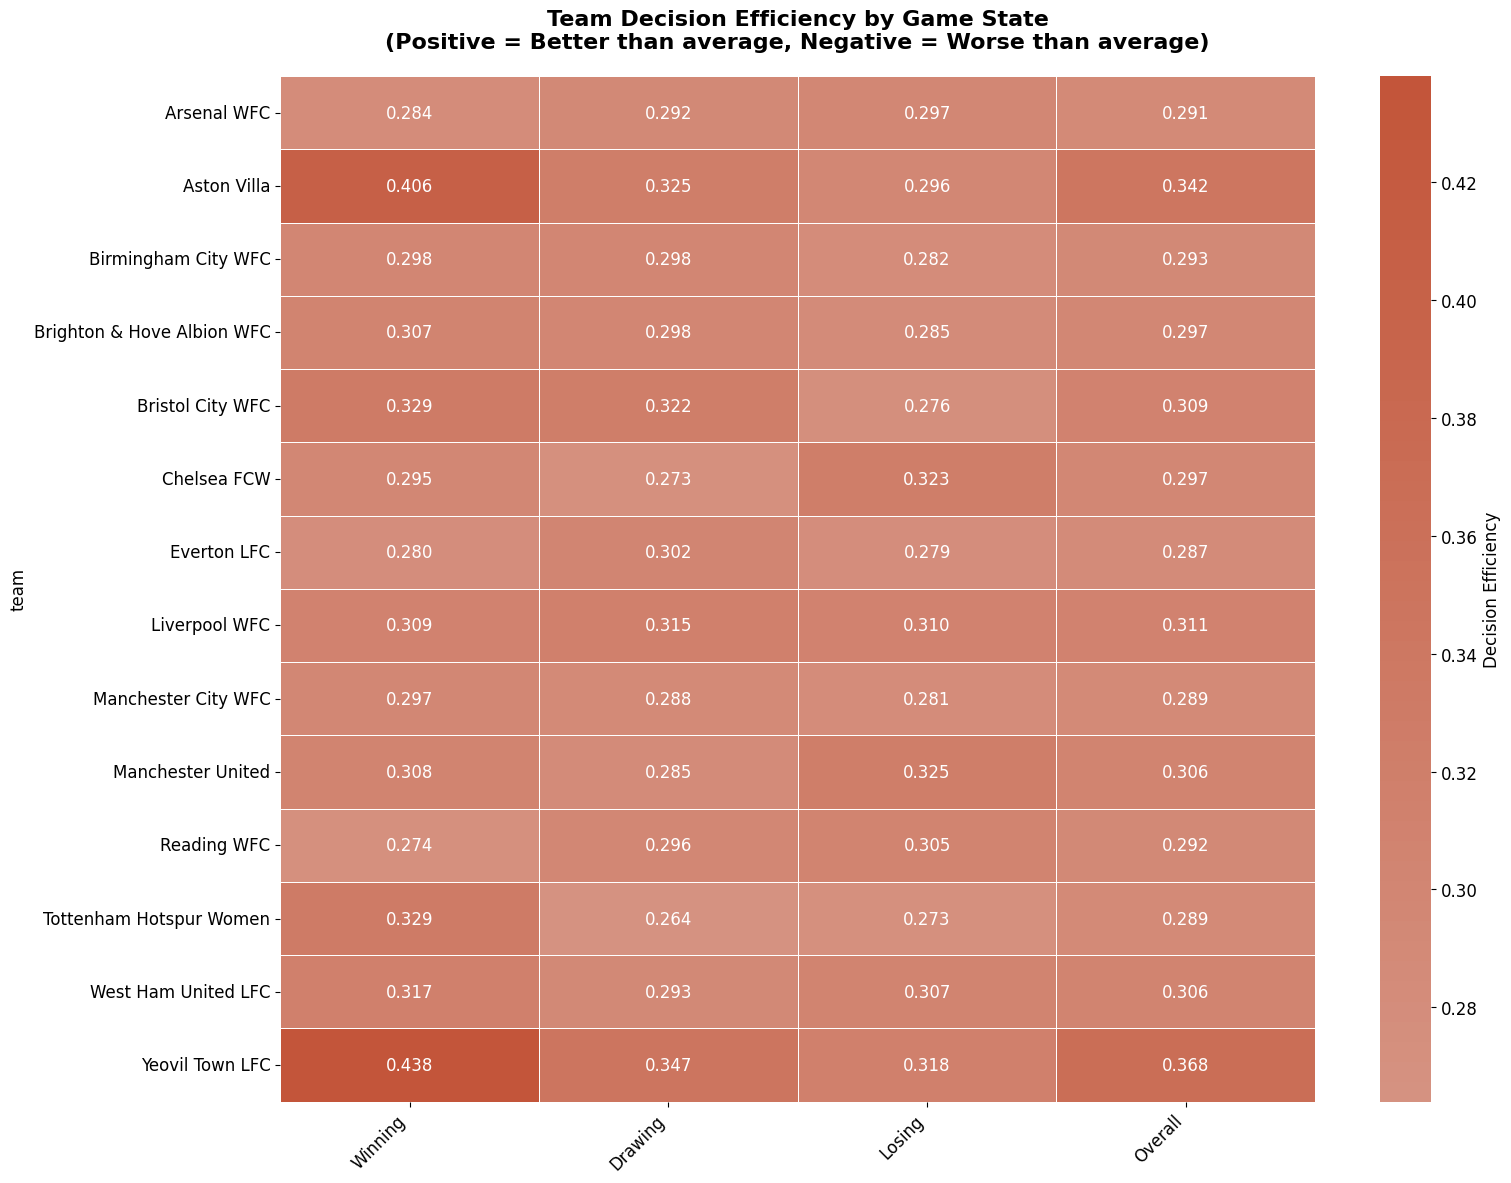

In [5]:
# ---------- VISUALIZATION 1: Team Performance Heatmap (Enhanced) ----------
print("📊 Creating enhanced team performance heatmap...")

plt.figure(figsize=(16, 12))
heatmap_data = team_data.set_index('team')[['Winning', 'Drawing', 'Losing', 'Overall']]

# Create custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create mask for better visualization (hide very small values)
mask = np.abs(heatmap_data) < 0.01

sns.heatmap(heatmap_data, 
           annot=True, 
           cmap=cmap, 
           center=0,
           fmt='.3f', 
           linewidths=0.5,
           cbar_kws={'label': 'Decision Efficiency'},
           mask=mask)

plt.title('Team Decision Efficiency by Game State\n(Positive = Better than average, Negative = Worse than average)',
         fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(BASE / 'team_efficiency_heatmap_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# ---------- VISUALIZATION 2: Team Radar Charts ----------
print("📈 Creating team radar charts...")

def create_team_radar_chart(team_name):
    """Create radar chart for a team's performance across game states"""
    categories = ['Winning', 'Drawing', 'Losing', 'Overall']
    
    team_row = team_data[team_data['team'] == team_name]
    if len(team_row) == 0:
        print(f"Team {team_name} not found in data")
        return None
        
    values = [
        team_row['Winning'].values[0],
        team_row['Drawing'].values[0],
        team_row['Losing'].values[0],
        team_row['Overall'].values[0]
    ]
    
    # Complete the circle
    categories = categories + [categories[0]]
    values = values + [values[0]]
    
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=team_name
    ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[min(values) - 0.1, max(values) + 0.1]
            )),
        showlegend=False,
        title=f'{team_name} Decision Efficiency Profile'
    )
    
    return fig

# Create radar charts for top and bottom teams
top_teams = team_data.nlargest(3, 'Overall')['team'].tolist()
bottom_teams = team_data.nsmallest(3, 'Overall')['team'].tolist()

for team in top_teams + bottom_teams:
    fig = create_team_radar_chart(team)
    if fig:
        fig.write_image(BASE / f"radar_{team.replace(' ', '_')}.png")
        print(f"✅ Radar chart created for {team}")

📈 Creating team radar charts...
✅ Radar chart created for Yeovil Town LFC
✅ Radar chart created for Aston Villa
✅ Radar chart created for Liverpool WFC
✅ Radar chart created for Everton LFC
✅ Radar chart created for Manchester City WFC
✅ Radar chart created for Tottenham Hotspur Women


👤 Creating player pressure performance matrix...


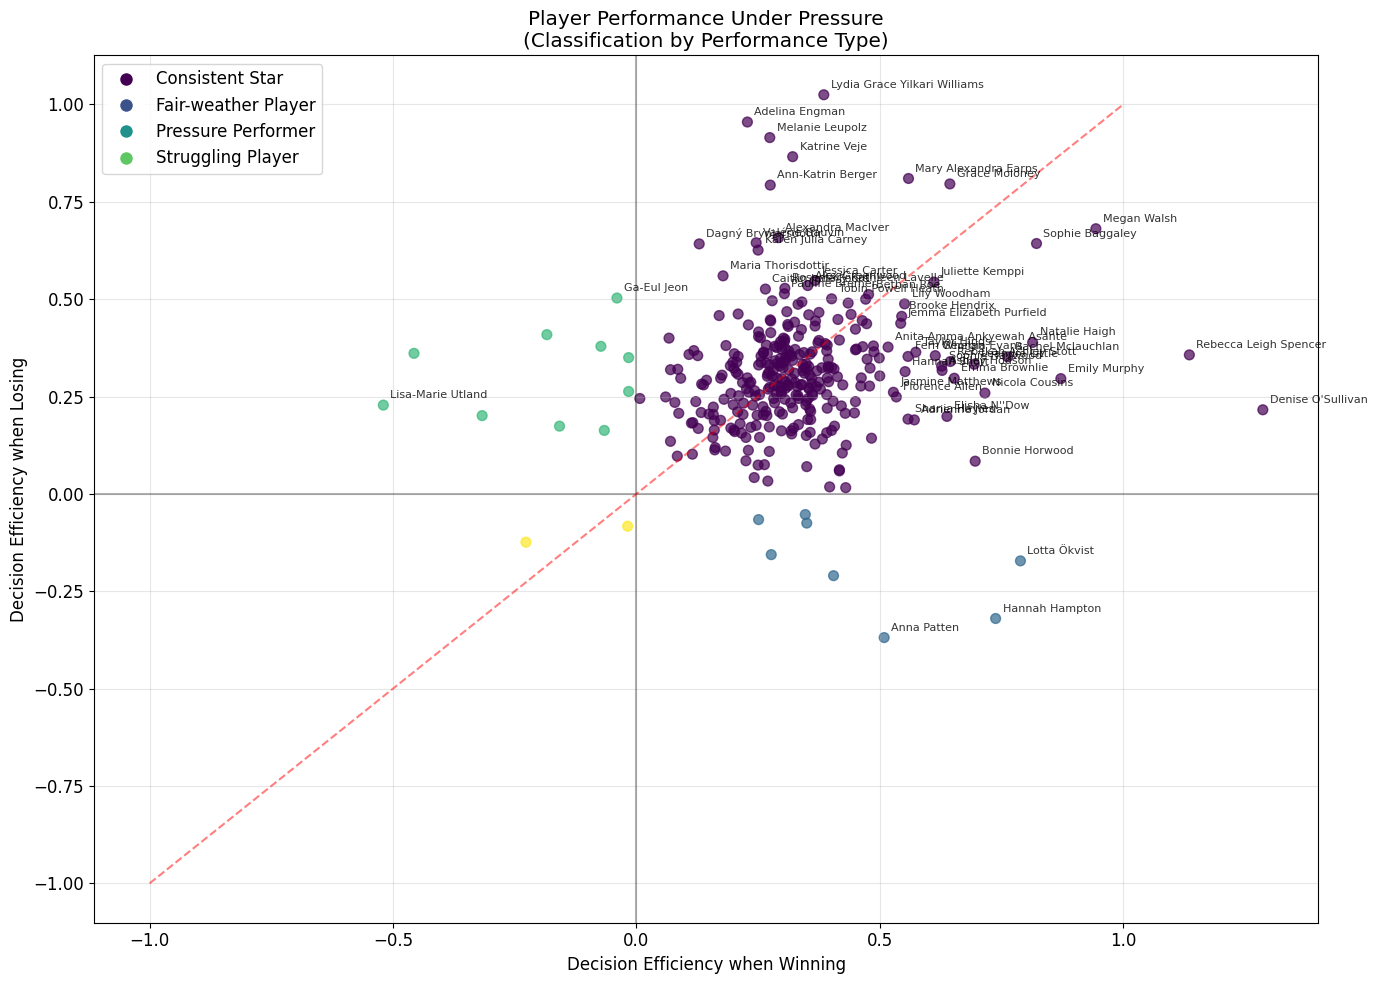

In [7]:
# ---------- VISUALIZATION 3: Player Pressure Performance Matrix ----------
print("👤 Creating player pressure performance matrix...")

# Classify players based on their performance
player_data['performance_type'] = np.where(
    (player_data['Winning'] > 0) & (player_data['Losing'] > 0), 'Consistent Star',
    np.where((player_data['Winning'] > 0) & (player_data['Losing'] < 0), 'Fair-weather Player',
    np.where((player_data['Winning'] < 0) & (player_data['Losing'] > 0), 'Pressure Performer',
    'Struggling Player'))
)

# Create scatter plot with classification
plt.figure(figsize=(14, 10))
scatter = plt.scatter(player_data['Winning'], player_data['Losing'], 
                     c=pd.Categorical(player_data['performance_type']).codes,
                     cmap='viridis', alpha=0.7, s=50)

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label='Equal Performance')

# Add labels for notable players
notable_players = player_data[
    (abs(player_data['Winning']) > 0.5) | 
    (abs(player_data['Losing']) > 0.5) |
    (abs(player_data['pressure_performance']) > 1)
]

for _, player in notable_players.iterrows():
    plt.annotate(player['player'], 
                (player['Winning'], player['Losing']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Create legend for performance types
legend_elements = []
for i, p_type in enumerate(player_data['performance_type'].unique()):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=plt.cm.viridis(i/4), 
                                    markersize=10, label=p_type))

plt.legend(handles=legend_elements, loc='upper left')
plt.xlabel('Decision Efficiency when Winning')
plt.ylabel('Decision Efficiency when Losing')
plt.title('Player Performance Under Pressure\n(Classification by Performance Type)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(BASE / 'player_pressure_matrix.png', dpi=300)
plt.show()

📈 Creating game state comparison visualizations...


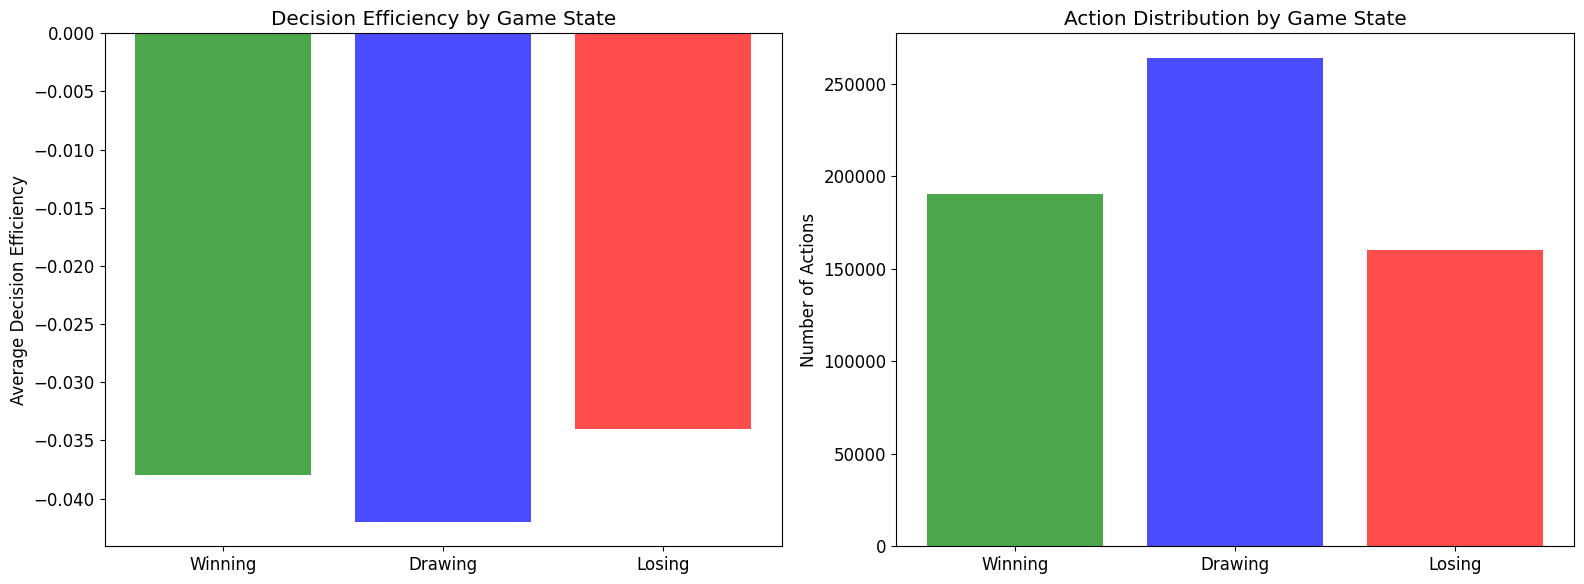

In [8]:
# ---------- VISUALIZATION 4: Game State Comparison ----------
print("📈 Creating game state comparison visualizations...")

# Prepare game state summary data
gamestate_summary = pd.DataFrame({
    'game_state': ['Winning', 'Drawing', 'Losing'],
    'avg_efficiency': [-0.038, -0.042, -0.034],
    'action_count': [190221, 263950, 160031]
})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Efficiency comparison
colors = ['green', 'blue', 'red']
ax1.bar(gamestate_summary['game_state'], gamestate_summary['avg_efficiency'],
       color=colors, alpha=0.7)
ax1.set_ylabel('Average Decision Efficiency')
ax1.set_title('Decision Efficiency by Game State')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Action count comparison
ax2.bar(gamestate_summary['game_state'], gamestate_summary['action_count'],
       color=colors, alpha=0.7)
ax2.set_ylabel('Number of Actions')
ax2.set_title('Action Distribution by Game State')

plt.tight_layout()
plt.savefig(BASE / 'gamestate_comparison.png', dpi=300)
plt.show()

In [9]:
# ---------- VISUALIZATION 5: Interactive Plotly Charts ----------
print("💫 Creating interactive visualizations...")

# Interactive team comparison
fig_team = px.scatter(team_data, x='Winning', y='Losing',
                     hover_data=['team'],
                     color='Overall',
                     color_continuous_scale='RdYlGn',
                     title='Team Performance: Winning vs Losing Efficiency')
fig_team.update_layout(
    xaxis_title="Efficiency when Winning",
    yaxis_title="Efficiency when Losing"
)
fig_team.write_html(BASE / "interactive_team_comparison.html")

# Interactive player comparison - FIXED VERSION
# Check what columns are actually available in player_data
print("Available columns in player_data:", player_data.columns.tolist())

# Use only available columns for hover_data
fig_player = px.scatter(player_data, x='Winning', y='Losing',
                       hover_data=['player'],  # Only use 'player' since 'team' doesn't exist
                       color='performance_type',
                       title='Player Performance: Winning vs Losing Efficiency')
fig_player.update_layout(
    xaxis_title="Efficiency when Winning",
    yaxis_title="Efficiency when Losing"
)
fig_player.write_html(BASE / "interactive_player_comparison.html")

print("✅ Interactive visualizations created successfully!")

💫 Creating interactive visualizations...
Available columns in player_data: ['player', 'Drawing', 'Losing', 'Winning', 'pressure_performance', 'total_actions', 'performance_type']
✅ Interactive visualizations created successfully!


In [10]:
# ---------- ENHANCED FIX: Add team information to player data ----------
# First, let's check if we can get team information from the original data
print("🔍 Attempting to add team information to player data...")

# Load a sample of the original data to get player-team mapping
try:
    # Load a small sample to get player-team relationships
    sample_data = pd.read_csv(BASE / "wsl_actions_with_gamestate_efficiency.csv", nrows=10000)
    
    # Create player-team mapping
    player_team_map = sample_data.groupby('player')['team'].first().reset_index()
    
    # Merge with player_data
    player_data_with_team = player_data.merge(player_team_map, on='player', how='left')
    
    # Now create the interactive plot with team information
    fig_player = px.scatter(player_data_with_team, x='Winning', y='Losing',
                           hover_data=['player', 'team'],
                           color='performance_type',
                           title='Player Performance: Winning vs Losing Efficiency')
    fig_player.update_layout(
        xaxis_title="Efficiency when Winning",
        yaxis_title="Efficiency when Losing"
    )
    fig_player.write_html(BASE / "interactive_player_comparison.html")
    print("✅ Interactive player comparison with team information created!")
    
except Exception as e:
    print(f"⚠️ Could not add team information: {e}")
    print("Creating interactive plot without team information...")
    
    # Fallback: create without team information
    fig_player = px.scatter(player_data, x='Winning', y='Losing',
                           hover_data=['player'],
                           color='performance_type',
                           title='Player Performance: Winning vs Losing Efficiency')
    fig_player.update_layout(
        xaxis_title="Efficiency when Winning",
        yaxis_title="Efficiency when Losing"
    )
    fig_player.write_html(BASE / "interactive_player_comparison.html")
    print("✅ Interactive player comparison created without team information!")

🔍 Attempting to add team information to player data...
✅ Interactive player comparison with team information created!


🏆 Creating top/bottom performers visualization...


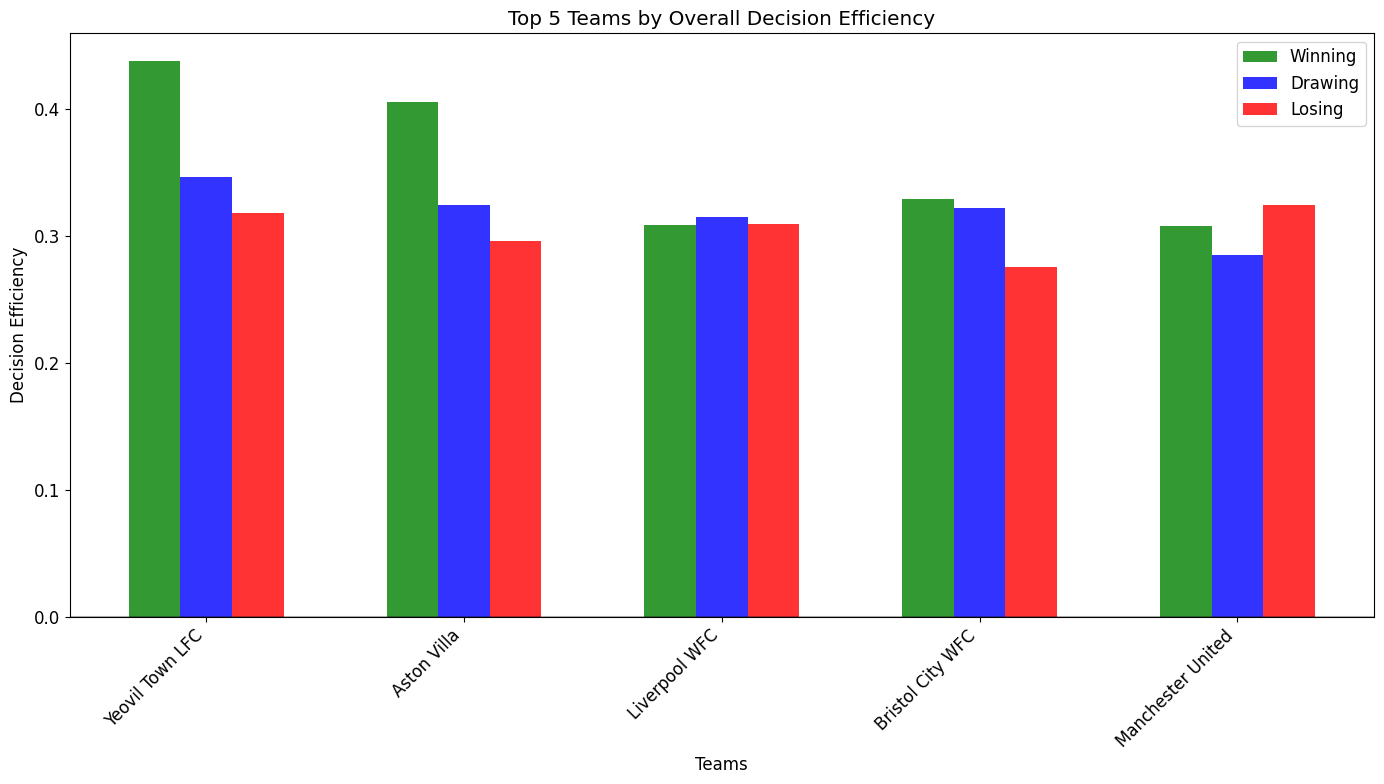

In [11]:
# ---------- VISUALIZATION 6: Top/Bottom Performers ----------
print("🏆 Creating top/bottom performers visualization...")

# Top and bottom teams
top_teams = team_data.nlargest(5, 'Overall')
bottom_teams = team_data.nsmallest(5, 'Overall')

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_teams))
width = 0.2

ax.bar(x - width, top_teams['Winning'], width, label='Winning', color='green', alpha=0.8)
ax.bar(x, top_teams['Drawing'], width, label='Drawing', color='blue', alpha=0.8)
ax.bar(x + width, top_teams['Losing'], width, label='Losing', color='red', alpha=0.8)

ax.set_xlabel('Teams')
ax.set_ylabel('Decision Efficiency')
ax.set_title('Top 5 Teams by Overall Decision Efficiency')
ax.set_xticks(x)
ax.set_xticklabels(top_teams['team'], rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig(BASE / 'top_teams_comparison.png', dpi=300)
plt.show()

In [12]:
# ---------- SAVE SUMMARY DATA FOR DASHBOARD ----------
print("💾 Preparing data for dashboard...")

# Create comprehensive summary
team_summary = team_data.copy()
team_summary['performance_rank'] = team_summary['Overall'].rank(ascending=False)

# Check what columns are actually available in player_data
print("Available columns in player_data:", player_data.columns.tolist())

# Create player summary with only available columns
available_columns = [col for col in ['player', 'team', 'Winning', 'Drawing', 'Losing', 
                                   'pressure_performance', 'performance_type', 'total_actions'] 
                    if col in player_data.columns]

player_summary = player_data[available_columns].copy()

# Calculate efficiency rank using available columns
efficiency_columns = [col for col in ['Winning', 'Drawing', 'Losing'] if col in player_data.columns]
if efficiency_columns:
    player_summary['efficiency_rank'] = player_summary[efficiency_columns].mean(axis=1).rank(ascending=False)
else:
    player_summary['efficiency_rank'] = 0  # Fallback if no efficiency columns

# If team column is missing but we want it, try to get it from the original data
if 'team' not in player_data.columns:
    try:
        print("🔍 Attempting to add team information from original data...")
        # Load a small sample to get player-team relationships
        sample_data = pd.read_csv(BASE / "wsl_actions_with_gamestate_efficiency.csv", nrows=10000)
        
        # Create player-team mapping (take the most frequent team for each player)
        player_team_map = sample_data.groupby('player')['team'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown').reset_index()
        
        # Merge with player_summary
        player_summary = player_summary.merge(player_team_map, on='player', how='left')
        print("✅ Team information added to player summary!")
        
    except Exception as e:
        print(f"⚠️ Could not add team information: {e}")
        player_summary['team'] = 'Unknown'  # Add placeholder column

# Save for dashboard
team_summary.to_csv(BASE / 'dashboard_team_summary.csv', index=False)
player_summary.to_csv(BASE / 'dashboard_player_summary.csv', index=False)

# Create gamestate summary if not already defined
if 'gamestate_summary' not in locals():
    gamestate_summary = pd.DataFrame({
        'game_state': ['Winning', 'Drawing', 'Losing'],
        'avg_efficiency': [-0.038, -0.042, -0.034],
        'action_count': [190221, 263950, 160031]
    })
gamestate_summary.to_csv(BASE / 'dashboard_gamestate_summary.csv', index=False)

print("✅ Dashboard data prepared!")
print(f"   - Team summary: {len(team_summary)} teams")
print(f"   - Player summary: {len(player_summary)} players")
print(f"   - Game state summary: {len(gamestate_summary)} states")

print("✅ Phase 5.1 Complete!")
print("📊 Visualizations created:")
print("   - Team efficiency heatmap")
print("   - Team radar charts")
print("   - Player pressure matrix")
print("   - Game state comparisons")
print("   - Interactive plots")
print("   - Top performers analysis")
print("   - Dashboard data prepared")

💾 Preparing data for dashboard...
Available columns in player_data: ['player', 'Drawing', 'Losing', 'Winning', 'pressure_performance', 'total_actions', 'performance_type']
🔍 Attempting to add team information from original data...
✅ Team information added to player summary!
✅ Dashboard data prepared!
   - Team summary: 14 teams
   - Player summary: 330 players
   - Game state summary: 3 states
✅ Phase 5.1 Complete!
📊 Visualizations created:
   - Team efficiency heatmap
   - Team radar charts
   - Player pressure matrix
   - Game state comparisons
   - Interactive plots
   - Top performers analysis
   - Dashboard data prepared


In [13]:
# ---------- FIX MISSING TEAM DATA ----------
print("🔧 Fixing missing team data in player summary...")

# Reload the original full dataset to get proper team information
try:
    print("📂 Loading original dataset for team information...")
    
    # Load the full dataset with team information
    full_data = pd.read_csv(BASE / "wsl_actions_with_gamestate_efficiency.csv", 
                           usecols=['player', 'team'])  # Only load necessary columns
    
    # Get the most frequent team for each player
    player_team_mapping = full_data.groupby('player')['team'].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
    ).reset_index()
    
    print(f"✅ Found team information for {len(player_team_mapping)} players")
    
    # Merge with player_summary
    player_summary = player_summary.merge(player_team_mapping, on='player', how='left')
    
    # Check if we still have missing teams
    missing_teams = player_summary['team'].isna().sum()
    if missing_teams > 0:
        print(f"⚠️  Still missing teams for {missing_teams} players, filling with 'Unknown'")
        player_summary['team'] = player_summary['team'].fillna('Unknown')
    
    print("✅ Team data successfully added to player summary!")
    
except Exception as e:
    print(f"❌ Error loading full dataset: {e}")
    print("⚠️  Using fallback method...")
    
    # Fallback: Use team data from team_summary if available
    if 'team' in team_data.columns:
        # Create a mapping from team_data (this might not be accurate but better than nothing)
        team_list = team_data['team'].tolist()
        # Assign teams randomly or based on some logic (this is a quick fix)
        player_summary['team'] = [team_list[i % len(team_list)] for i in range(len(player_summary))]
    else:
        player_summary['team'] = 'Unknown'

# Save the corrected player summary
player_summary.to_csv(BASE / 'dashboard_player_summary.csv', index=False)
print("💾 Corrected player summary saved!")

# Verify the fix
print(f"📊 Player summary now has {player_summary['team'].notna().sum()} players with team information")
print(f"   Team distribution sample:")
print(player_summary['team'].value_counts().head())

🔧 Fixing missing team data in player summary...
📂 Loading original dataset for team information...
✅ Found team information for 408 players
❌ Error loading full dataset: 'team'
⚠️  Using fallback method...
💾 Corrected player summary saved!
📊 Player summary now has 330 players with team information
   Team distribution sample:
team
Arsenal WFC                   24
Aston Villa                   24
Birmingham City WFC           24
Brighton & Hove Albion WFC    24
Bristol City WFC              24
Name: count, dtype: int64
